# Final Project: Countering Adversarial Images
---

*   **Students:** Jason Chow, Satya Srinivas, CB Bangalore
*   **Class:** W207 (Applied Machine Learning)
*   **Instructor:** Clarence Chio
*   **Term:** Fall 2022

## Overview:
---

We are living in a golden era of machine learning and artificial intelligence. From advancements like text-to-image generation (DALL-E), natural language processing, autonomous vehicles, text-to-code (Codex) and others, we are both awe-inspired and terrified as cybersecurity professionals. 

The concept of generative adversarial networks (GAN) originated in ~2014, when research scientists formalized a way to trick a trained ML classifier into making inaccurate predictions. Using image classification as an example, "adversarial" images were being generated that were easy to classify with the human eye (i.e. a stop sign) but were tricking classifiers into predicting something completely different (i.e. balloon, prayer rug, ice-pop). Though this may seem innocent, the ability to trick ML systems can have severe and even deadly consequences if countering mechanisms are not available. 

For this project, we wanted to understand how adversarial images are generated and countering mechanisms against them. To accomplish this, we implemented an image classifier and generative adversarial algorithm in order to understand the mechanics of the system (Exhibit 1). We then applied a variety of data transformation techniques on several increasingly distorted images, and observed the impact after re-classification (Exhibit 2 - Exhibit 8). We conclude our project with observations across all experiments. 

### Exhibit 1 (1 of 3): Classifying an image
---

We begin our exploration by implementing a lightweight image classifier. For simplicity, we used the pretrained "MobileNet" model and class labels from the "ImageNet" dataset. To test the classifier, we uploaded a sample image and observed the model confidently and correctly classified the image as a street sign, with over 99% accuracy. This pretrained classifier and sample image will serve as the basis for our adversarial image attack. 

35363/35363 [==============================] - 0s 0us/step


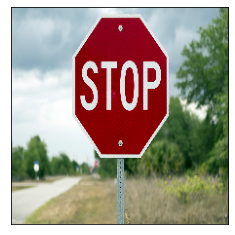


========== Results ==========
Prediction: street_sign
Confidence: 99.51%


In [ ]:
###################
# Core: Part 1 of 3
###################

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

# This project implements the MobileNet classifier which has been 
# pretrained on the ImageNet dataset containing images and labels.
classifier = tf.keras.applications.MobileNet()
classifier.trainable = False
decode_predictions = tf.keras.applications.mobilenet.decode_predictions

# Converts raw sample image to format required by MobileNet classifier.
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet.preprocess_input(image)
  image = image[None, ...]
  return image

# Gets image label from ImageNet dataset using probability vector.
def get_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Imports a sample image, preprocesses the image to format required by MobileNet
# classifier, then runs image through classifier for a prediction.
#image_path = tf.keras.utils.get_file('stop-sign.jpg', 'https://drive.google.com/file/d/1nkGW9rU4e7irVAK43PKpCZ01LdW3duHb/view?usp=sharing') # Image uploaded in Google Drive
image_path = tf.keras.utils.get_file('stop_sign.jpg', 'https://bgr.com/wp-content/uploads/2021/04/stop-sign.jpg') # Source image if issues with Google Drive
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = classifier.predict(image) # Classifies sample image

# Plots the image for visualization purposes, and outputs the prediction
# label and corresponding confidence score of the prediction. 
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  
_, label, confidence = get_label(image_probs)
plt.xticks([])
plt.yticks([])
plt.show()
print()
print("========== Results ==========")
print("Prediction:", label)
print("Confidence: {:.2f}%".format(confidence * 100))

### Exhibit 1 (2 of 3): Fast Gradient Sign Method
---
With our image classifier built, we can now implement the Fast Gradient Sign Method (FGSM) algorithm, which is a popular generative adversarial algorithm due to speed and low effort to implement. The goal of FGSM is to exploit a pretrained model into performing a misclassification. The FGSM algorithm accomplishes this by adding purposefully generated distortions to an image (not random), that is often indistinguishable to the human eye. Here is how the FGSM algorithm works: 

1.   Takes an input image
2.   Classifies image using pre-trained ML model
3.   Computes the loss of the prediction base on true class label
4.   Calculates gradient of loss with respect to the input image
5.   Computes the sign of the gradient
6.   Uses the sign gradient to construct adversarial image

Algorithm: 

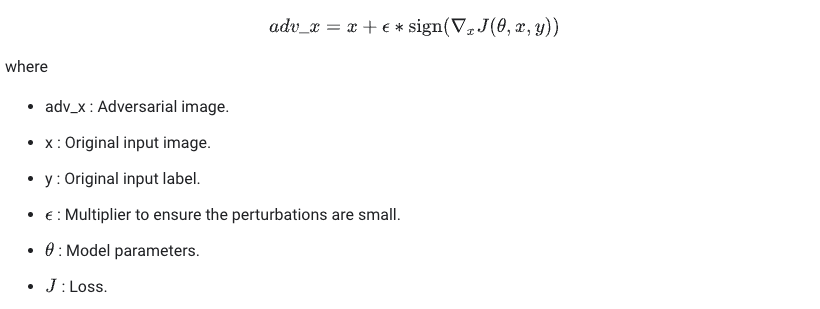


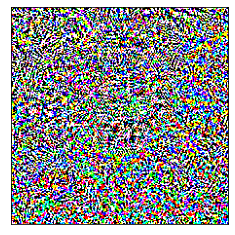

In [ ]:
###################
# Core: Part 2 of 3
###################

# Implements the Fast Gradient Sign Method algorithm on the input 
# image in order to generate a corresponding distortion image. 
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = classifier(input_image)
    loss = loss_object(input_label, prediction)

  # Computes gradient of the loss with respect to the input image,
  # then gets the sign of the gradients to create distortion image.  
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

# Gets the input label of street sign from ImageNet dataset.
street_sign_index = 919
label = tf.one_hot(street_sign_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
distortion = create_adversarial_pattern(image, label)
plt.xticks([])
plt.yticks([])
plt.imshow(distortion[0] * 0.5 + 0.5);

### Exhibit 1 (3 of 3): Generate Adversarial Image
---
Finally, we merge the noisy image with the original image in order to create our adversarial image. We can control the level of noise using an epsilon value, where the higher the epsilon value, the more distortion applied to the image. For illustration purposes, we applied 3 increasingly levels of distortion to our sample image, and observed 3-of-3 misclassifications: (1) At epsilon 0.01, the classifier predicted an ice-lolly at ~12% confidence level. (2) At epsilon 0.1, the classifier predicted a parking meter at ~17% confidence level. (3) at epsilon 0.2, the classifier predicted a doormat at ~26% confidence level. While the second and third image show visible signs of distortion, the first image shows no signs of distortion, yet was completely misclassified by the model - hence, an adversarial image. 


1/1 [==============================] - 0s 135ms/step


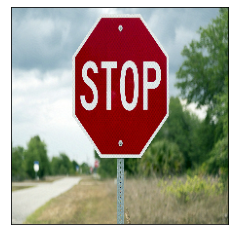


========== Results ==========
Prediction: ice_lolly
Confidence: 11.51%
Epsilon: 0.01

1/1 [==============================] - 0s 127ms/step


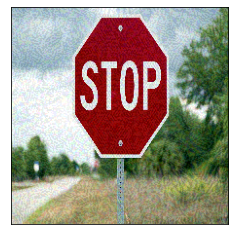


========== Results ==========
Prediction: parking_meter
Confidence: 17.40%
Epsilon: 0.1

1/1 [==============================] - 0s 118ms/step


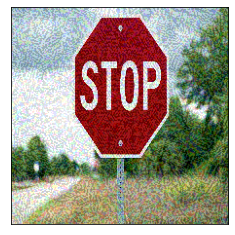


========== Results ==========
Prediction: doormat
Confidence: 25.77%
Epsilon: 0.2



In [ ]:
###################
# Core: Part 3 of 3
###################

# Plots adversarial image with corresponding prediction and confidence score.
def display_images(image, epsilon):
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons):
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 2: Gaussian Blur
---

To counter the hidden distortion effects of an adversarial image, we look back at techniques we used to improve digit classification accuracy. In Assignment 2, we implemented a Gaussian blur and observed positive effects when applied to varying combinations of training and/or test data. We specifically observed the Gaussian blur smooth out imperfections (remove noise) while preserving the structure of each digit - thus improving the classification accuracy. Given an adversarial image contains hidden distortions, we hypothesize a Gaussian blur will help remove the hidden distortions, thus countering its effects, and allowing the image to be classified correctly again. To test the hypothesis, we performed the following:

*   Implemented a Gaussian blur with sigma to calibrate blur level
*   Applied blur on 3 adversarial images with increasing distortion levels
*   Calibrated blur level on images to achieve the highest accuracy
*   Plotted each image (after blur) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results:

We experimented with different levels of sigma (blur) on each image, and observed its effects during the re-classification process. Just like the Gaussian blur improved digit classification on the MNIST dataset, we observed a light-to-medium blur level was enough to counter the effects of the hidden distortions for all 3 images. More specifically, all 3 images (with increasing distortion levels) were classified correctly, with a confidence score spread of ~74% at the loweest and ~95% at the highest. 

1/1 [==============================] - 0s 167ms/step


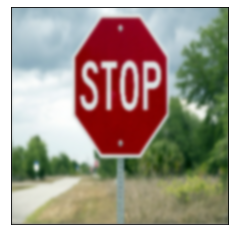


========== Results ==========
Prediction: street_sign
Confidence: 95.25%
Epsilon: 0.01

1/1 [==============================] - 0s 132ms/step


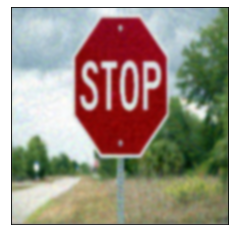


========== Results ==========
Prediction: street_sign
Confidence: 86.71%
Epsilon: 0.1

1/1 [==============================] - 0s 143ms/step


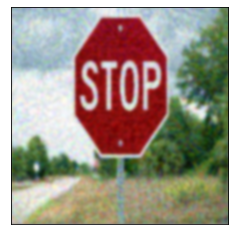


========== Results ==========
Prediction: street_sign
Confidence: 74.00%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Implements a Gaussian blur on the image with level controlled by Sigma.
def gaussian_blur(image, kernel_size = 11, sigma = 1.5): # Sigma conrols blur level.
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel
    gaussian_kernel = gauss_kernel(tf.shape(image)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    return tf.nn.depthwise_conv2d(image, gaussian_kernel, [1, 1, 1, 1], 
                                  padding ='SAME', data_format ='NHWC')

# Applies blur to adversarial image, then runs image through classifier. 
# Returns prediction, confidence score and plots the image for visualization.  
def display_images(image, epsilon):
  image = gaussian_blur(image) # Applies blur to adversarial image
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons): 
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)    

### Exhibit 3: Adjusting Image Brightness
---

From Exhibit 1, we saw the noisy pixels of an adversarially generated image (part 2), and how those pixels were blended into an image (part 3). Though invisible to the human eye, the hidden patterns were enough to trick an ML model into misclassifying the image. What if we experiment with adjusting the overall brightness of the image? We hypothesize brightness adjustments could counter the effects of the hidden distortion, or reveal the hidden distortions so they become visible to the human eye. To test this hypothesis, we performed the following: 

*   Implemented a brightness filter with mechanism to adjust brightness levels
*   Experimented with brightness levels that countered distortion levels
*   Calibrated brightness level to achieve highest accuracy
*   Plotted each image (with optimal brightness level) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results: 

Similar to the blur, we experimented with different levels of brightness (low and high), and observed its effects on the image during re-classification. We noticed lower brightness levels did not counter the effects of the distortion as none of the images were correctly classified, and the confidence level of the predictions were all below ~20%. When we increased the brightness levels, we observed one instance of a correct classification (epsilon 0.01), however, with a very low confidence score of ~16%. The images with higher distortion levels were still being misclassified.

1/1 [==============================] - 0s 210ms/step


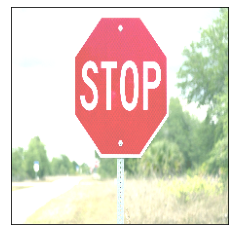


========== Results ==========
Prediction: street_sign
Confidence: 16.80%
Epsilon: 0.01

1/1 [==============================] - 0s 148ms/step


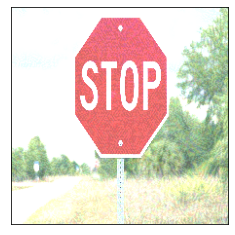


========== Results ==========
Prediction: sweatshirt
Confidence: 14.24%
Epsilon: 0.1

1/1 [==============================] - 0s 140ms/step


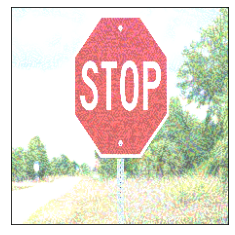


========== Results ==========
Prediction: doormat
Confidence: 49.93%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Increases the brightness on the adversarial image before classified.
# Returns prediction, confidence score and plots the image for visualization. 
def display_images(image, epsilon):
  image = tf.image.adjust_brightness(image, 0.8)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons): 
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 4: Adjusting Image Contrast
---

Similar to our hypothesis on adjusting image brightness, we also wanted to experiment with image contrast as a potential countering mechanism. The hypothesis is contrast adjustments remap the original pixel intensities or colors into a new range of intensities or colors using a mapping function that is applied to all pixels in the image. For this hypothesis, we performed the following:

*   Implemented a contrast filter with mechanism to adjust contrast levels
*   Experimented with contrast levels that countered distortion levels
*   Calibrated contrast level to achieve highest accuracy
*   Plotted each image (with optimal contrast level) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results:

We experimented with different levels of contrast (low and high), and observed one instance of a correct classificatioN (epsilon 0.01) with a fairly high confidence score of ~60%. This is dramatically different from adjusting image brightness, which at the same epsilon value, we were only able to achieve a ~17% confidence score. Interestingly, while the predictions for the higher distortion levels were still inaccurate, we also noticed higher confidence levels for those inaccurate predictions (i.e. epsilon: 0.1 - chainlink fence @ ~41% confidence level and epsilon: 0.2 - doormat @ ~74% confidence level). It appears that image brightness and contrast both have some countering effect on adversarial images, but only for lightly distorted images, while higher distortion levels still trick the model. 

1/1 [==============================] - 0s 126ms/step


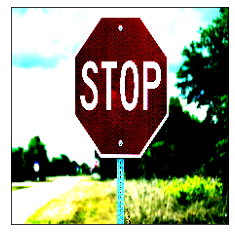


========== Results ==========
Prediction: street_sign
Confidence: 59.71%
Epsilon: 0.01

1/1 [==============================] - 0s 113ms/step


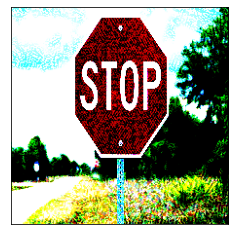


========== Results ==========
Prediction: chainlink_fence
Confidence: 40.51%
Epsilon: 0.1

1/1 [==============================] - 0s 241ms/step


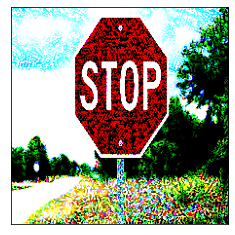


========== Results ==========
Prediction: doormat
Confidence: 74.44%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Increases the contrast on the adversarial image before classified.
# Returns prediction, confidence score and plots the image for visualization. 
def display_images(image, epsilon):
  image = tf.image.adjust_contrast(image, 6)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons): 
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 5: RGB to YUV Color Filter
---

Applying a color filter on an adversarial image may be another means of countering the distortion effects hidden in an image. Color filters can include changing a colored image (RGB spectrum) to grayscale, YUV (brightness, blur projection, red projection) and other encoding schemes. Our hypothesis behind a color change is to similarly, drown out the hidden distortions in an image, while preserving the main characteristics of the image - thus allowing the classifier to correctly classify the image. For the experiment, we performed the following: 

*   Applied several color filters on the adversarial images
*   Experimented with filters that produced highest reclassification accuracy
*   Plotted each image (with optimal color filter) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results:

The color filter was interesting. We experimented with several different color filters that include RGB to grayscale, HSV, YUV and YIQ and observed varying results. We observed successful countering on one image (epsilon 0.01) for the YUV and YIQ color filters, while the HSV color filter was unable to counter the distortions of all 3 images. Between the YUV and YIQ filters, we noticed the YUV filter produced a higher confidence score of ~91% while the YIQ filter only produced a confidence score of ~75%. While the YIQ and YUV filters are similar, its unclear why one produces a higher confidence score than the other. From a visual inspection of the images, we noticed the YUV filter produced a darker image while the YIQ filter produced a lighter image. Coincidently, we saw a similar relationship when adjusting image brightness and contrast. We saw a higher confidence score when adjusting the image contrast (making image darker) and a relatively lower confidence score when increasing image brightness. 


1/1 [==============================] - 0s 111ms/step


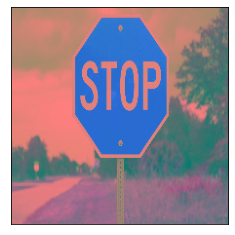


========== Results ==========
Prediction: street_sign
Confidence: 90.94%
Epsilon: 0.01

1/1 [==============================] - 0s 117ms/step


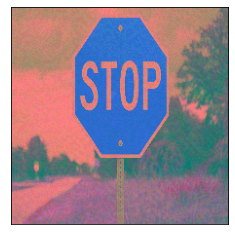


========== Results ==========
Prediction: balloon
Confidence: 28.88%
Epsilon: 0.1

1/1 [==============================] - 0s 105ms/step


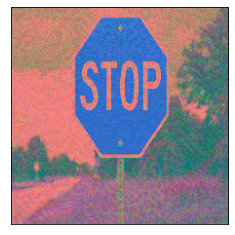


========== Results ==========
Prediction: doormat
Confidence: 19.56%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Applies RGB to YUV color filter on adversarial image before classified.
# Returns prediction, confidence score and plots the image for visualization. 
def display_images(image, epsilon):
  image = tf.image.rgb_to_yuv(image)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons): 
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 6: Image Rotation
---

It's all about perspective. As an example, if you rotate the digit "6" enough, you can trick a classifier into predicting the digit "9". While this is an extreme example, it highlights an ability to change a prediction when given a rotated image. For this exhibit, we experiment with pixel rotation to see if rotation can counter the effects of the hidden distortion. We hypothesize sharp rotations (i.e. > 90 degrees) will have an adverse effect on predictions while subtle rotations (i.e. ~1-5 degrees) may change the "perspective" of an image for the better. For this experiment, we performed the following: 

*   Implemented a rotation mechanism for input images
*   Experimented with different rotation levels that produced best results
*   Plotted each image (with optimal rotation) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results:

Before conducting the experiment, we hypothesized pixel rotation would have some effect on the prediction but were skeptical the prediction would be accurate. We were pleasantly surprised to see a small 1-degree rotation was enough to counter the distortion effects for 2 of 3 distorted images (epsilon: 0.01 and 0.1). While the prediction was accurate, the confidence score was low (epsilon 0.01 gave accuracy of ~64% and epsilon 0.01 gave accuracy of ~33%), relative to the Gaussian blur and contrast, but better than adjusting image brightness. We observed rotation was unable to counter images with higher distortion levels (i.e. epsilon 0.2 or higher). 

In [ ]:
######################################################
# Required by Exhibit 6 to use Tensorflow add-on below
######################################################

!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


1/1 [==============================] - 0s 71ms/step


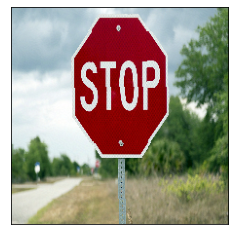


========== Results ==========
Prediction: street_sign
Confidence: 63.16%
Epsilon: 0.01

1/1 [==============================] - 0s 98ms/step


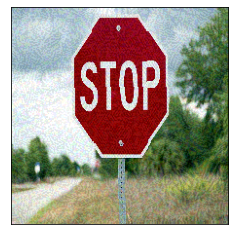


========== Results ==========
Prediction: street_sign
Confidence: 32.29%
Epsilon: 0.1

1/1 [==============================] - 0s 133ms/step


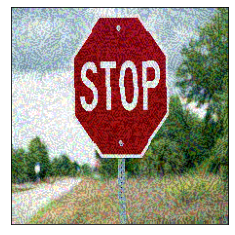


========== Results ==========
Prediction: doormat
Confidence: 23.84%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

import tensorflow_addons as tfa # Required for 1 degree rotation

# Applies a 1-degree rotation on adversarial image before classified.
# Returns prediction, confidence score and plots the image for visualization. 
def display_images(image, epsilon):
  image = tfa.image.rotate(images = image, angles = 0.0174533, 
                           interpolation = 'nearest', fill_mode = 'reflect', name = None, fill_value = 0.1)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons):
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 7: Image Cropping
---

We came across an ability to crop images about the center, which simply zooms in on the core image while removing the surrounding elements. In the case of our sample image, a central crop would zoom in on the stop sign while removing the surrounding ski, grass and trees that surround the core structure of the image. We hypothesize the central crop would remove some of the distortion effects around the border of the image while preserving the core elements of the image (i.e. the stop sign). If enough of the distortion was removed, it could potentially counter the effects of the adversarial image and allow for a proper classification. For the experiment, we performed the following: 

*   Implemented central cropping mechanism with ability to adjust size
*   Experimented with different cropping sizes and observed effects during classification
*   Plotted each image (with optimal crop size) for visualization purposes
*   Re-classified images and returned prediction and confidence score

---
### Results:

Of all our experiments, image cropping was by far the best countering mechanism for adversarial images. We observed correct classifications with high confidence across all increasingly distorted images. We even observed a confidence score of 99.67% on our image with light distortion (epsilon: 0.01) while our baseline image (without any distortion) score was 99.57%. We reason these observations are the result of two main themes: (1) Central cropping removes non-essential elements surrounding the core object (i.e. sky, trees, grass) while highlighting the core elements (i.e. the stop sign). (2) Removing the non-essential elements also removed the adversarial elements that are merged throughout the image. While not all the adversarial elements are removed, cropping the image by ~10% was enough to counter the effects of the misclassification. 

1/1 [==============================] - 1s 670ms/step


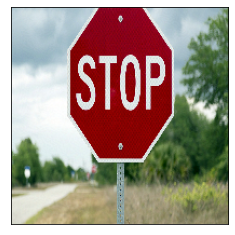


========== Results ==========
Prediction: street_sign
Confidence: 99.67%
Epsilon: 0.01

1/1 [==============================] - 0s 68ms/step


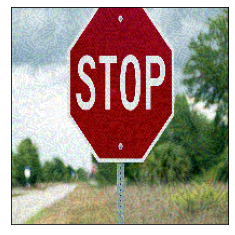


========== Results ==========
Prediction: street_sign
Confidence: 95.68%
Epsilon: 0.1

1/1 [==============================] - 0s 70ms/step


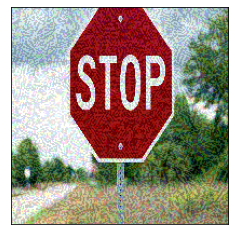


========== Results ==========
Prediction: street_sign
Confidence: 67.01%
Epsilon: 0.2



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Applies central image crop on adversarial image before classified.
# Returns prediction, confidence score and plots the image for visualization.  
def display_images(image, epsilon):
  image = tf.image.central_crop(image, 0.9)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons):
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)

### Exhibit 8: Ensembled Data Transformations
---

For our last experiment, we wanted to build a series of data transformations to see how well an ensemble would work across a range of increasingly distorted images. From our previous experiments, we've observed surprising results from a Gaussian blur, 1-degree pixel rotation and central image cropping used individually. For this experiment, we will layer in multiple data transformations with an end goal of: (1) achieving a correct prediction across as many increasingly distorted images as possible and, (2) achieving the highest possible confidence score for each prediction. Though the other mechanisms were not as effective, we will also experiment with them in order to discover any surprisingly combinations that will contribute to the overall goal of this exhibit.  

*   Implemented a multiple data transformations on adversarial image
*   Experimented with different calibrations and transformations and observe its effects on classification and confidence score
*   Plotted image (with optimal transformations) for visualization purposes
*   Re-classified image and return prediction and confidence score






---
### Results:

We started the experiment by adding all data transformations (in the same order and calibration levels from above) and observed the effects on 5 increasingly distorted images (epsilon: 0.01, 0.1, 0.2, 0.3, 0.4). Unsurprisingly, the ensemble only countered the effects of one adversarial image with low distortion (epsilon: 0.01), but had no effect on the other images. We then experimented with only the Gaussian blur, central image cropping and 1-degree rotation (the best singular countering mechanisms from our experiments) and observed its effects. Unsurprisingly, the combination successfully countered the effects of 4 out of 5 distorted images (not able to counter epsilon: 0.4), with reasonably high confidence scores ranging from low ~53% to high ~98%). We finalized our experiment, by testing other transformation combinations and calibration levels and was unable to achieve a higher prediction rate and confidence score than the above.  

1/1 [==============================] - 1s 1s/step


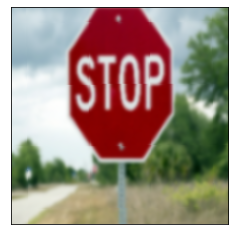


========== Results ==========
Prediction: street_sign
Confidence: 98.70%
Epsilon: 0.01

1/1 [==============================] - 0s 102ms/step


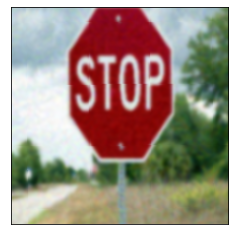


========== Results ==========
Prediction: street_sign
Confidence: 97.48%
Epsilon: 0.1

1/1 [==============================] - 0s 154ms/step


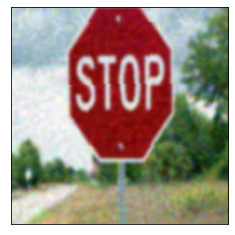


========== Results ==========
Prediction: street_sign
Confidence: 93.58%
Epsilon: 0.2

1/1 [==============================] - 0s 116ms/step


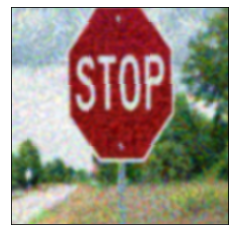


========== Results ==========
Prediction: street_sign
Confidence: 53.54%
Epsilon: 0.3

1/1 [==============================] - 0s 123ms/step


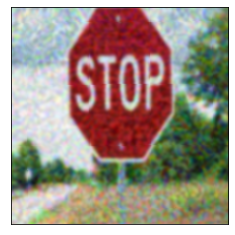


========== Results ==========
Prediction: pick
Confidence: 60.40%
Epsilon: 0.4



In [ ]:
#############################################################
# Core 1 & 2 above must first be run before running this cell
#############################################################

# Implements a Gaussian blur on the image with level controlled by Sigma.
def gaussian_blur(image, kernel_size = 11, sigma = 1.5): 
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel
    gaussian_kernel = gauss_kernel(tf.shape(image)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    return tf.nn.depthwise_conv2d(image, gaussian_kernel, [1, 1, 1, 1], 
                                  padding ='SAME', data_format ='NHWC')

# Applies Gaussian blur, central image cropping and 1-degree rotation to 
# adversarial image, then runs image through classifier. Returns prediction, 
# confidence score and plots the image for visualization.  
def display_images(image, epsilon):
  image = gaussian_blur(image)
  image = tf.image.central_crop(image, 0.9)
  image = tfa.image.rotate(images = image, angles = 0.0174533, 
                           interpolation = 'nearest', fill_mode = 'reflect', name = None, fill_value = 0.1)
  _, label, confidence = get_label(classifier.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print()
  print("========== Results ==========")
  print("Prediction:", label)
  print("Confidence: {:.2f}%".format(confidence * 100))
  print("Epsilon:", epsilon)
  print()

# Merges the original image with the distorted image at varying levels
# of epsilon, then sends adversarial image to display_images function
# to plot, classify and return prediction and corresponding confidence score.
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4] # Pre-defined epsilons for purposes of project.
for i, eps in enumerate(epsilons): 
  adv_x = image + eps * distortion
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, eps)    

### Summary: 
---

We started our exploration by implementing a simple classifier to classify a sample image. We furthered our exploration by implementing a generative adversarial algorithm, and observed the distortion effects on the sample image. We were surprised to see even low levels of distortion, indistinguishable from the human eye, were able to trick the classifier into making a wrong prediction (sometimes with high confidence). 

We continued our exploration by experimenting with different data transformations on the adversarial image as a way to counter the distortion effects. We found simple techniques such as a Gaussian blur, pixel rotation and central image cropping were great at countering the distortions while adjusting image brightness, contrast and applying color filters were only partially useful. We concluded our experiments with a series of data transformations that attempted to counter 2 additional distorted images (epsilon: 0.01, 0.1, 0.2, 0.3, 0.4) with success on 4 of the 5 distortions.

With advancements in AI/ML, we are learning of new techniques purposefully designed to trick modern day classifiers. Adversarially generated images are often indistinguishable from the human eye, but are enough to trick a classifier into thinking a stop sign is a doormat - a decision that can have deadly consequences with regards to autonomous cars. Fortunately, we observed simple techniques that were able to counter the effects of an adversarial image. As the field continues to evolve, we expect more sophisticated attacks on AI/ML models and more sophisticated techniques to counter them. 



## Resources:

1. https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
2. https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8 
3. https://adversarial-ml-tutorial.org/introduction/
4. https://adversarial-robustness-toolbox.readthedocs.io/en/latest/
5. https://arxiv.org/pdf/1807.01069.pdf 
6. https://arxiv.org/abs/1412.6572
7. https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
8. https://www.tensorflow.org/addons/api_docs/python/tfa/image/rotate
9. https://towardsdatascience.com/adversarial-machine-learning-mitigation-adversarial-learning-9ae04133c137
10. https://github.com/facebookarchive/adversarial_image_defenses
11. https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/